# MFBO test: accelerating fire (20 min arrival)
Using the new two-fidelity SR BO (autoregressive co-kriging) with an accelerating ROS schedule.


In [15]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

from fire_model.ca import FireEnv, CAFireModel
from fire_model.bo_sr import RetardantDropBayesOptSR

warnings.filterwarnings("ignore", message=".*balance properties of Sobol.*")
np.set_printoptions(precision=3, suppress=True)


In [16]:
# Configuration (copied/adapted from experiment_early_detection_vs_drones)
CFG = {
    'grid': {
        'size': (150, 150),
        'domain_km': 3.0,
        'dt_s': 5.0,
    },
    'low_grid': {
        'size': (96, 96),  # coarse grid for low fidelity
        'dt_s': 5.0,
    },
    'fire': {
        'ros_mps': 0.1,
        'ros_accel_tau_s': 1200.0,
        'wind': (0.35, 0.10),
        'burn_time_s0': 600.0,
        'retardant_half_life_s': 7200.0,
        'retardant_k': 1.0,
        'retardant_cell_cap': 2.5,
        'wind_coeff': 0.55,
        'drop_w_km': 0.02,
        'drop_h_km': 0.40,
        'drop_amount': 1.0,
        'avoid_burning_drop': True,
    },
    'ignition': {
        'center_frac': (0.42, 0.45),
        'radius_km': 0.05,
    },
    'bo': {
        'seed': 13,
        'n_drones': 5,
        'evolution_time_s': 1200.0,  # 20 minutes
        'search_grid_evolution_time_s': 1200.0,
        'n_sims_high': 30,
        'n_init_high': 10,
        'n_iters': 80,
        'n_candidates': 1500,
        'xi': 0.02,
        'candidate_strategy': 'mixed',
        'candidate_qmc': 'sobol',
        'candidate_local_frac': 0.5,
        'candidate_local_top_k': 4,
        'candidate_local_sigma_s': 0.04,
        'candidate_local_sigma_r': 0.04,
        'candidate_local_sigma_delta_rad': np.deg2rad(10.0),
        'candidate_local_resample_delta_prob': 0.05,
        'init_strategy': 'heuristic',
        'init_heuristic_random_frac': 0.3,
        'init_heuristic_kwargs': {'value_power': 2.4, 'r_offset': -0.02, 'jitter_delta_rad': np.deg2rad(8.0)},
        'init_value_r_offset': -0.02,
        'init_value_jitter_r': 0.02,
        'init_value_jitter_s': 0.01,
    },
    'mfbo': {
        'n_init_low': 10,
        'low_n_sims': 15,
        'low_evolution_time_s': 1200.0,
        'mf_warmup_low': 4,
        'mf_low_per_high': 2,
        'mf_low_cost': 0.2,
        'mf_high_cost': 1.0,
        'mf_max_low': 50,
        'mf_max_high': 30,
        'mf_rho_bounds': (0.1, 10.0),
        'mf_verbose': True,
        'mf_log_top_k_ei': 5,
    },
    'search_grid': {
        'fire_boundary_probability': 0.25,
        'K_grid': 180,
        'boundary_field': 'affected',
        'n_r': 150,
        'smooth_iters': 200,
        'omega': 1.0,
    },
}


In [17]:
# Helper functions

def build_ros_schedule(ros_ss_mps: float, tau_s: float, dt_s: float, total_s: float) -> np.ndarray:
    steps = int(np.ceil(total_s / dt_s))
    t = np.arange(steps) * dt_s
    if tau_s is None or tau_s <= 0:
        return np.full(steps, ros_ss_mps, dtype=float)
    ramp = 1.0 - np.exp(-t / float(tau_s))
    return ros_ss_mps * ramp

def build_env(cfg, grid_override: dict | None = None):
    grid = dict(cfg['grid'])
    if grid_override:
        grid.update(grid_override)
    fire = cfg['fire']
    horizon_s = cfg['bo']['evolution_time_s']
    ros_sched = build_ros_schedule(
        ros_ss_mps=fire['ros_mps'],
        tau_s=fire['ros_accel_tau_s'],
        dt_s=grid['dt_s'],
        total_s=horizon_s + 600.0,
    )
    fuel = np.ones(grid['size'], dtype=float)
    value = np.ones_like(fuel)
    wind_field = np.broadcast_to(np.array(fire['wind'], dtype=float), grid['size'] + (2,))
    env = FireEnv(
        grid_size=grid['size'],
        domain_km=grid['domain_km'],
        fuel=fuel,
        value=value,
        wind=wind_field,
        dt_s=grid['dt_s'],
        burn_time_s0=fire['burn_time_s0'],
        retardant_half_life_s=fire['retardant_half_life_s'],
        retardant_k=fire['retardant_k'],
        retardant_cell_cap=fire['retardant_cell_cap'],
        drop_w_km=fire['drop_w_km'],
        drop_h_km=fire['drop_h_km'],
        drop_amount=fire['drop_amount'],
        ros_mps=ros_sched,
        wind_coeff=fire['wind_coeff'],
        avoid_burning_drop=fire['avoid_burning_drop'],
    )
    return env

def make_init_state(model: CAFireModel, cfg):
    gx, gy = model.env.grid_size
    cx = int(cfg['ignition']['center_frac'][0] * gx)
    cy = int(cfg['ignition']['center_frac'][1] * gy)
    return model.init_state_batch(n_sims=1, center=(cx, cy), radius_km=cfg['ignition']['radius_km'])


In [18]:
env_hi = build_env(CFG)
fire_model = CAFireModel(env_hi, seed=CFG['bo']['seed'])
init_state = make_init_state(fire_model, CFG)

env_low = build_env(CFG, grid_override=CFG['low_grid'])
fire_model_low = CAFireModel(env_low, seed=CFG['bo']['seed'])
init_state_low = make_init_state(fire_model_low, CFG)

print('High grid', env_hi.grid_size, 'dx_km', fire_model.dx, 'dt_s', env_hi.dt_s)
print('Low grid ', env_low.grid_size, 'dx_km', fire_model_low.dx, 'dt_s', env_low.dt_s)


High grid (150, 150) dx_km 0.02 dt_s 5.0
Low grid  (96, 96) dx_km 0.03125 dt_s 5.0


In [19]:
bo = RetardantDropBayesOptSR(
    fire_model=fire_model,
    init_firestate=init_state,
    n_drones=CFG['bo']['n_drones'],
    evolution_time_s=CFG['bo']['evolution_time_s'],
    n_sims=CFG['bo']['n_sims_high'],
    fire_boundary_probability=CFG['search_grid']['fire_boundary_probability'],
    search_grid_evolution_time_s=CFG['bo']['search_grid_evolution_time_s'],
    rng=np.random.default_rng(CFG['bo']['seed']),
)

mf_opts = {
    'n_init_low': CFG['mfbo']['n_init_low'],
    'low_n_sims': CFG['mfbo']['low_n_sims'],
    'low_evolution_time_s': CFG['mfbo']['low_evolution_time_s'],
    'low_fire_model': fire_model_low,
    'low_init_firestate': init_state_low,
    'low_scale_params': True,
    'mf_warmup_low': CFG['mfbo']['mf_warmup_low'],
    'mf_low_per_high': CFG['mfbo']['mf_low_per_high'],
    'mf_low_cost': CFG['mfbo']['mf_low_cost'],
    'mf_high_cost': CFG['mfbo']['mf_high_cost'],
    'mf_max_low': CFG['mfbo']['mf_max_low'],
    'mf_max_high': CFG['mfbo']['mf_max_high'],
    'mf_rho_bounds': CFG['mfbo']['mf_rho_bounds'],
    'mf_verbose': CFG['mfbo']['mf_verbose'],
    'mf_log_top_k_ei': CFG['mfbo']['mf_log_top_k_ei'],
    'mf_return_history': True,
}


In [ ]:
best_theta, best_params, best_y, (Xh, yh), y_nexts_high, y_bests_high, mf_trace = bo.run_bayes_opt(
    n_init=CFG['bo']['n_init_high'],
    n_iters=CFG['bo']['n_iters'],
    n_candidates=CFG['bo']['n_candidates'],
    xi=CFG['bo']['xi'],
    K_grid=CFG['search_grid']['K_grid'],
    boundary_field=CFG['search_grid']['boundary_field'],
    n_r=CFG['search_grid']['n_r'],
    smooth_iters=CFG['search_grid']['smooth_iters'],
    omega=CFG['search_grid']['omega'],
    verbose=True,
    print_every=1,
    use_ard_kernel=False,
    init_strategy=CFG['bo']['init_strategy'],
    init_heuristic_random_frac=CFG['bo']['init_heuristic_random_frac'],
    init_heuristic_kwargs=CFG['bo']['init_heuristic_kwargs'],
    init_value_r_offset=CFG['bo']['init_value_r_offset'],
    init_value_jitter_r=CFG['bo']['init_value_jitter_r'],
    init_value_jitter_s=CFG['bo']['init_value_jitter_s'],
    candidate_strategy=CFG['bo']['candidate_strategy'],
    candidate_qmc=CFG['bo']['candidate_qmc'],
    candidate_local_frac=CFG['bo']['candidate_local_frac'],
    candidate_local_top_k=CFG['bo']['candidate_local_top_k'],
    candidate_local_sigma_s=CFG['bo']['candidate_local_sigma_s'],
    candidate_local_sigma_r=CFG['bo']['candidate_local_sigma_r'],
    candidate_local_sigma_delta_rad=CFG['bo']['candidate_local_sigma_delta_rad'],
    candidate_local_resample_delta_prob=CFG['bo']['candidate_local_resample_delta_prob'],
    eval_seed=CFG['bo']['seed'],
    use_mfbo=True,
    mf_options=mf_opts,
)
print('Best high-fidelity objective', best_y)
print('Best params (x,y,phi):', best_params)
print('Trace length', len(mf_trace), 'entries')

No drone_params


Total evaluations: 8 | low=6 | high=2
First 5 entries (iter, fid, y, rho, best_high):
  it=01 fid= low y=0.02897 rho=3.53 best_high=0.1264
  it=02 fid= low y=0.03206 rho=3.54 best_high=0.1264
  it=03 fid= low y=0.02832 rho=3.54 best_high=0.1264
  it=04 fid= low y=0.02865 rho=3.55 best_high=0.1264
  it=05 fid=high y=0.1266 rho=3.55 best_high=0.1264


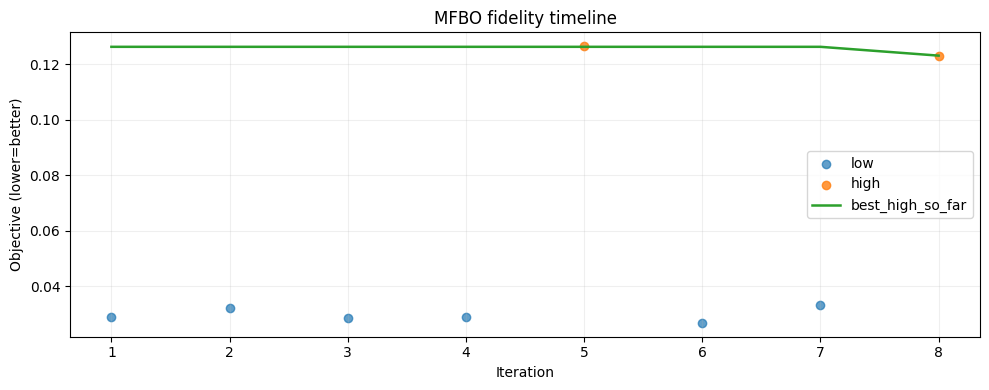

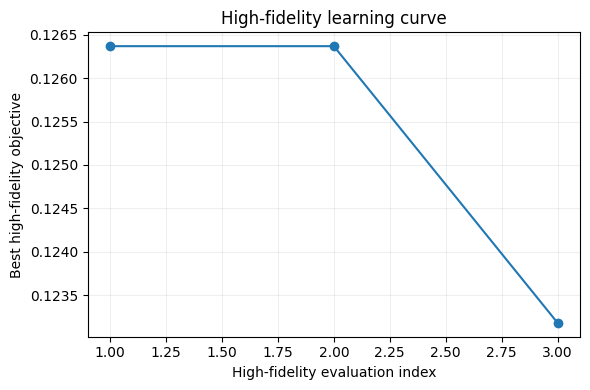

In [ ]:
# Fidelity timeline and learning curves
import numpy as np
import matplotlib.pyplot as plt

iters = np.array([t['iter'] for t in mf_trace])
fids = np.array([t['fidelity'] for t in mf_trace])
y_nexts = np.array([t['y_next'] for t in mf_trace])
best_high_overall = np.array([t['best_high'] for t in mf_trace])

low_mask = fids == 'low'
high_mask = fids == 'high'

print(f"Total evaluations: {len(mf_trace)} | low={low_mask.sum()} | high={high_mask.sum()}")
print("First 5 entries (iter, fid, y, rho, best_high):")
for t in mf_trace[:5]:
    print(f"  it={t['iter']:02d} fid={t['fidelity']:>4s} y={t['y_next']:.4g} rho={t['rho']:.3g} best_high={t['best_high']:.4g}")

plt.figure(figsize=(10, 4))
plt.scatter(iters[low_mask], y_nexts[low_mask], color='tab:blue', label='low', alpha=0.7)
plt.scatter(iters[high_mask], y_nexts[high_mask], color='tab:orange', label='high', alpha=0.8)
plt.plot(iters, best_high_overall, color='tab:green', label='best_high_so_far', linewidth=1.8)
plt.xlabel('Iteration')
plt.ylabel('Objective (lower=better)')
plt.title('MFBO fidelity timeline')
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(y_bests_high)+1), y_bests_high, marker='o')
plt.xlabel('High-fidelity evaluation index')
plt.ylabel('Best high-fidelity objective')
plt.title('High-fidelity learning curve')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


In [ ]:
# Optional: plot the best plan at high fidelity (can be slow).
# _ = bo.plot_evolved_firestate(best_theta, n_sims=CFG['bo']['n_sims_high'], title_prefix='MFBO best (high fidelity)')
